## **클래스 활성화 맵**

클래스 활성화 히트맵은 특정 출력 클래스에 대해 입력 이미지의 모든 위치를 계산한 2D 점수 그리드이다. 클래스에 대해 각 위치가 얼마나 중요한지를 표시해준다.

'입력 이미지가 각 채널을 활성화하는 정도'에 대한 공간적인 맵을 '클래스에 대한 각 채널의 중요돟'로 가중치를 부여하여 '입력 이미지가 크래스를 활성화 하는 정도'에 대한 공간적인 맵을 만드는 것이다. 








/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


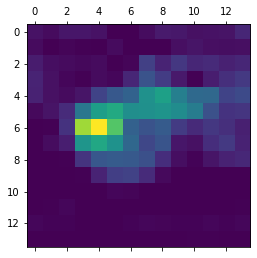

<Figure size 432x288 with 0 Axes>

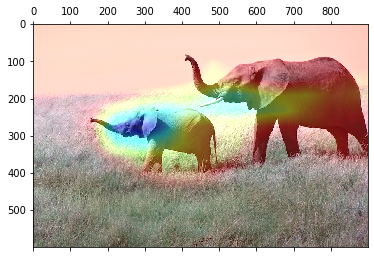

In [31]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K # 케라스 백엔드 함수
import cv2

model = VGG16(weights = 'imagenet')

img_path = '/content/creaetive_common_elephant.jpg'
img = image.load_img(img_path, target_size = (224, 224))
x = image.img_to_array(img)

x = np.expand_dims(x, axis = 0)
x = preprocess_input(x) # VGG16 전용 이미지 전처리 함수

preds = model.predict(x)
print(np.argmax(preds)) # 아프리카 코끼리의 확률 점수를 나타내는 index를 계산한다. (386)

african_elephant_output = model.output[:, 386]

tf.compat.v1.disable_eager_execution()
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis = (0, 1, 2,))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis = -1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

plt.figure()

# OpenCV를 사용하여 앞에서 얻은 히트맵에 원본 이미지를 겹친 이미지를 마든다.
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # heatmap 사이즈를 변경한다.
heatmap = np.uint8(255 * heatmap) # RGB 형식으로 포맷한다.
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img # 0.4는 heatmap 강도를 나타낸다.
superimposed_img /= 255.
plt.matshow(superimposed_img)